In [2]:
import joblib
import os
from tensorflow import keras

In [3]:
from text_prep import load_dataset, load_descriptions, clean_descriptions, to_vocabulary
from photo_prep import Extractor, Extractor_alt
from model import RnnModel, sequencer, generate_seq

# Loading and preparing the data

In [20]:
# uncomment to create the caption dictionary

# path = 'data\Flickr8k_text\Flickr8k.token.txt'
# captions = clean_descriptions(load_descriptions(path))

# joblib.dump('captions.pkl')

In [4]:
# uncomment to create the features dictionary

# extract = Extractor()
# features = extract.extract_features('data/Flicker8k_Dataset')
# print('Extracted Features: %d' % len(features))
# joblib.dump(features, 'features.pkl')

In [5]:
# The lists of image IDs are loaded

train_path = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
test_path = 'data/Flickr8k_text/Flickr_8k.testImages.txt'

train_dataset = load_dataset(train_path)
test_dataset = load_dataset(test_path)

In [7]:
captions = joblib.load('captions.pkl')
features = joblib.load('features.pkl')

In [8]:
def load_feat_descr(dict, dataset):
    return {k: dict[k] for k in dataset}

In [9]:
captions_train = load_feat_descr(captions, train_dataset)
features_train = load_feat_descr(features, train_dataset)
captions_test = load_feat_descr(captions, test_dataset)
features_test = load_feat_descr(features, test_dataset)

In [10]:
# uncomment if you want to create a new vocabulary

# vocab = to_vocabulary(captions_train)
# joblib.dump(vocab, 'vocabulary.pkl')

vocab = joblib.load('final_model/vocabulary.pkl')

In [11]:
vc = keras.layers.TextVectorization(
    vocabulary = ['startseq'] + vocab + ['endseq']
)

In [12]:
max_len = 0
for key in captions_train.keys():
    for d in captions_train[key]:
        max_len = max(max_len, len(d))
max_len        

36

# The model

In [13]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [22]:
inputs_fe = Input(shape=(1000,))
fe1 = Dropout(0.5)(inputs_fe)
fe2 = Dense(256, activation='relu')(fe1)

inputs_se = Input(shape=(max_len+2,))
se1 = Embedding(len(vocab)+2, 256, mask_zero=True)(inputs_se)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, activation='tanh')(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(len(vocab)+4, activation='softmax')(decoder2)

model = Model(inputs=[inputs_fe, inputs_se], outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 38, 256)      1421312     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 1000)         0           ['input_3[0][0]']                
                                                                                            

## Training with generator

In [24]:
generator = generate_seq(train_dataset, captions_train, features_train, vc, max_len)
generator_val = generate_seq(test_dataset, captions_test, features_test, vc, max_len)

val_loss_list = []
steps = len(train_dataset)
steps_val = len(test_dataset)

In [26]:
epochs=4

for i in range(epochs):
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    val_loss = model.evaluate(generator_val, steps= steps_val, verbose=1)
    val_loss_list.append(val_loss)
    if val_loss == min(val_loss_list):
        model.save('./models/model_tiny_' + str(val_loss) + '.h5')

1000/1000 [==============================] - 122s 123ms/step - loss: 3.3777


# Evaluation

## Try out some predictions

In [42]:
from keras.utils import load_img
from keras.models import load_model

directory = 'data/Flicker8k_Dataset'
model_path = 'final_model/model_3.288113594055176.h5'

rnn = RnnModel(load_model(model_path), vocab, max_len)

In [43]:
path = 'data\Flickr8k_text\Flickr_8k.devImages.txt'
dataset_f = load_dataset(path)
len(dataset_f)

1000

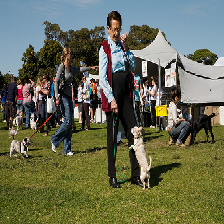

In [44]:
name = dataset_f[99]
image = features[name]
picture = load_img(directory + '/' + name + '.jpg', target_size=(224,224))
picture

In [45]:
pred = rnn.predict(image)
pred

['a', 'dog', 'run', 'through', 'the', 'grass']

## Evaluation by BLEU

In [39]:
from nltk.translate.bleu_score import corpus_bleu

In [46]:
references = []
predictions = []
for name in dataset_f:
    references.append(captions[name])
    predictions.append(rnn.predict(features[name]))


In [47]:
print('BLEU-1', corpus_bleu(references, predictions, weights=(1.0, 0.0, 0.0, 0.0)))
print('BLEU-2', corpus_bleu(references, predictions, weights=(0.5, 0.5, 0.0, 0.0)))
print('BLEU-3', corpus_bleu(references, predictions, weights=(0.33, 0.33, 0.33, 0.0)))
print('BLEU-4', corpus_bleu(references, predictions, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1 0.48277583624563153
BLEU-2 0.2746869024108206
BLEU-3 0.1477342391152633
BLEU-4 0.07733355392413663
